In [1]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify

In [2]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
# Load the model you trained in task5_training.ipynb
from tensorflow.keras.models import load_model
example_file_name = f'RonLevTabuchov_221846_unet_model_9_256px_ACC77.h5'
model = load_model(example_file_name, custom_objects={"f1": f1})

In [4]:
# Define any functions you need to process the mask e.g. Task 2

In [4]:
# Load the test image
task5_test_image_path = 'task5_test_image.png'
image = cv2.imread(task5_test_image_path, 0)
h, w = image.shape
print(h, w)

3006 4112


In [5]:
def detect_edges(image, max_size=2800):
    """ Detect edges to find the approximate square Petri dish. """
    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(image, (51, 51), 0)

    # Compute horizontal and vertical gradients
    sobel_x = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=5)
    sobel_y = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=5)

    # Calculate the gradient magnitude
    gradient_magnitude = cv2.magnitude(sobel_x, sobel_y)

    # Threshold to identify strong edges
    _, edges = cv2.threshold(gradient_magnitude, 50, 255, cv2.THRESH_BINARY)
    edges = edges.astype(np.uint8)

    # Find contours to identify the Petri dish
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Assume the largest square-like contour is the Petri dish
    max_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(max_contour)

    # Ensure the crop is a square, adjust dimensions as needed
    side_length = max(w, h)
    side_length = min(side_length, max_size)  # Clamp to max_size

    center_x, center_y = x + w // 2, y + h // 2
    half_side = side_length // 2

    # Define new bounding box that is a square centered at the original bounding box
    new_x = max(center_x - half_side, 0)
    new_y = max(center_y - half_side, 0)
    new_w = new_h = min(side_length, min(image.shape[1] - new_x, image.shape[0] - new_y))

    return new_x, new_x + new_w, new_y, new_y + new_h


In [6]:
edges = detect_edges(image)
print("Detected Edges:", edges)


Detected Edges: (747, 3547, 52, 2852)


In [7]:
def crop_image(image, edges, max_size=2800):
    """ Crop and resize the image to ensure dimensions are below the threshold. """
    left, right, top, bottom = edges
    cropped = image[top:bottom, left:right]

    # Resize if necessary
    if cropped.shape[1] > max_size or cropped.shape[0] > max_size:
        cropped = cv2.resize(cropped, (min(cropped.shape[1], max_size), min(cropped.shape[0], max_size)))

    return cropped


Cropped Image Shape: (2800, 2800)


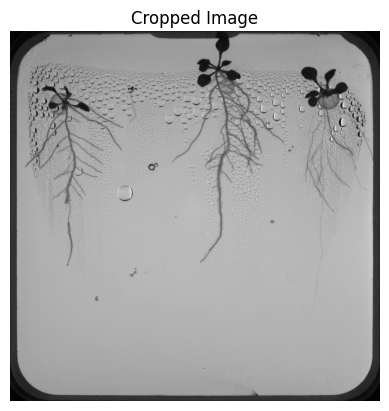

In [8]:
cropped_image = crop_image(image, edges)
print("Cropped Image Shape:", cropped_image.shape)

# Display the cropped image
plt.figure(dpi=100)
plt.imshow(cropped_image, cmap='gray')
plt.title("Cropped Image")
plt.axis('off')
plt.show()


In [9]:
# Find the petri dish
cropped_image.shape

(2800, 2800)

In [10]:
def pad_image(image, patch_size=256):
    """ Pad the image to make its dimensions compatible with the patch size. """
    h, w = image.shape
    pad_h = (patch_size - (h % patch_size)) % patch_size
    pad_w = (patch_size - (w % patch_size)) % patch_size

    padded_image = np.pad(
        image,
        ((0, pad_h), (0, pad_w)),
        mode='constant',
        constant_values=0
    )
    return padded_image


Padded Image Shape: (2816, 2816)


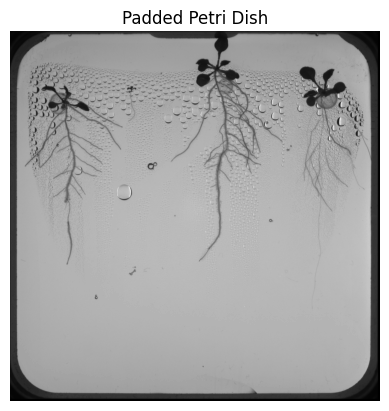

In [11]:
petri_dish_padded = pad_image(cropped_image)
print("Padded Image Shape:", petri_dish_padded.shape)

# Visualize the padded image
plt.figure(dpi=100)
plt.imshow(petri_dish_padded, cmap='gray')
plt.title("Padded Petri Dish")
plt.axis('off')
plt.show()


In [12]:
# Pad the petri dish
petri_dish_padded.shape

(2816, 2816)

In [13]:
from patchify import patchify, unpatchify
import numpy as np
import matplotlib.pyplot as plt

# Padding Function
def pad_image(image, patch_size=256):
    """ Pad the image to make its dimensions compatible with the patch size. """
    h, w = image.shape
    pad_h = (patch_size - (h % patch_size)) % patch_size
    pad_w = (patch_size - (w % patch_size)) % patch_size
    return np.pad(image, ((0, pad_h), (0, pad_w)), mode='constant', constant_values=0)

# Patching Function
def patchify_image(image, patch_size=256):
    """ Divide the image into smaller patches of the given size. """
    return patchify(image, (patch_size, patch_size), step=patch_size)

# Prediction Function
def predict_patches(patches, model, batch_size=32):
    """ Run predictions on each patch using the correct input and batch size. """
    # Prepare the patches for prediction (reshape to include channel dimension)
    num_patches = patches.shape[0] * patches.shape[1]
    reshaped_patches = patches.reshape((num_patches, patches.shape[2], patches.shape[3], 1))  # Add channel dim

    # Predict in batches
    predictions = model.predict(reshaped_patches, batch_size=batch_size)

    # Reshape predictions back to the patch grid
    predicted_patches = predictions.reshape(
        patches.shape[0], patches.shape[1], patches.shape[2], patches.shape[3]
    )
    return predicted_patches


# Unpatching Function
def unpatchify_image(patches):
    """ Reconstruct the full image from patches. """
    return unpatchify(patches, (patches.shape[0] * patches.shape[2], patches.shape[1] * patches.shape[3]))

# Padding the Petri Dish
patch_size = 256
petri_dish_padded = pad_image(cropped_image, patch_size=patch_size)
print("Padded Image Shape:", petri_dish_padded.shape)

# Patching
patches = patchify_image(petri_dish_padded, patch_size=patch_size)
print("Patches Shape:", patches.shape)

# Prediction
predicted_patches = predict_patches(patches, model)
print("Predicted Patches Shape:", predicted_patches.shape)

# Unpatching
predicted_mask = unpatchify_image(predicted_patches)
print("Predicted Mask Shape:", predicted_mask.shape)

# Visualization
f, ax = plt.subplots(1, 2, dpi=300, figsize=(10, 5))
ax[0].imshow(petri_dish_padded, cmap='gray')
ax[0].axis('off')
ax[0].set_title('task5_test_image.png')

ax[1].imshow(predicted_mask, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Prediction')
plt.show()


Padded Image Shape: (2816, 2816)
Patches Shape: (11, 11, 256, 256)


NotFoundError: Graph execution error:

Detected at node 'model_1/conv2d_29/Relu' defined at (most recent call last):
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\35988\AppData\Local\Temp\ipykernel_21352\2179279495.py", line 50, in <module>
      predicted_patches = predict_patches(patches, model)
    File "C:\Users\35988\AppData\Local\Temp\ipykernel_21352\2179279495.py", line 26, in predict_patches
      predictions = model.predict(reshaped_patches, batch_size=batch_size)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\35988\anaconda3\envs\Block_b_GPU\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'model_1/conv2d_29/Relu'
No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1#TC: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4839): 'status'
  Profiling failure on CUDNN engine 1: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4839): 'status'
  Profiling failure on CUDNN engine 0#TC: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4839): 'status'
  Profiling failure on CUDNN engine 0: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4839): 'status'
  Profiling failure on CUDNN engine 2#TC: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4839): 'status'
  Profiling failure on CUDNN engine 2: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4839): 'status'
  Profiling failure on CUDNN engine 6#TC: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4839): 'status'
  Profiling failure on CUDNN engine 6: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4839): 'status'
  Profiling failure on CUDNN engine 5#TC: UNKNOWN: CUDNN_STATUS_INTERNAL_ERROR
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4839): 'status'
  Profiling failure on CUDNN engine 5: UNKNOWN: CUDNN_STATUS_INTERNAL_ERROR
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4839): 'status'
  Profiling failure on CUDNN engine 7#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 337643776 bytes.
  Profiling failure on CUDNN engine 7: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 337643776 bytes.
	 [[{{node model_1/conv2d_29/Relu}}]] [Op:__inference_predict_function_2541]

In [15]:
def reverse_padding(mask, original_shape):
    """ Remove padding to match the original image dimensions. """
    return mask[:original_shape[0], :original_shape[1]]

# Reverse padding
predicted_mask_corrected = reverse_padding(predicted_mask, petri_dish_padded.shape)
print("Shape after reversing padding:", predicted_mask_corrected.shape)


Shape after reversing padding: (2816, 2816)


In [17]:
# Print the crop coordinates (edges)
print("Crop Coordinates (edges):", edges)

# Ensure the edges make sense relative to the original image shape
print("Original Image Shape:", image.shape)


Crop Coordinates (edges): (747, 3547, 52, 2852)
Original Image Shape: (3006, 4112)


In [18]:
# Compute the expected crop dimensions
expected_height = edges[3] - edges[2]
expected_width = edges[1] - edges[0]
print("Expected Cropped Mask Shape:", (expected_height, expected_width))

# Actual cropped mask shape
print("Cropped Mask Shape:", predicted_mask_corrected.shape)

# Check if they match
if predicted_mask_corrected.shape == (expected_height, expected_width):
    print("Cropped mask dimensions match the expected crop size.")
else:
    print("Mismatch in cropped mask dimensions!")


Expected Cropped Mask Shape: (2800, 2800)
Cropped Mask Shape: (2816, 2816)
Mismatch in cropped mask dimensions!


In [19]:
# Calculate padding added during the padding step
pad_h = predicted_mask_corrected.shape[0] - 2800
pad_w = predicted_mask_corrected.shape[1] - 2800
print("Padding Added - Height:", pad_h, "Width:", pad_w)


Padding Added - Height: 16 Width: 16


In [21]:
def uncrop_image(cropped_mask, original_shape, crop_coordinates):
    """ Embed the cropped mask into the original image dimensions. """
    full_mask = np.zeros(original_shape, dtype=cropped_mask.dtype)
    x_start, x_end, y_start, y_end = crop_coordinates
    full_mask[y_start:y_end, x_start:x_end] = cropped_mask
    return full_mask

# Assuming crop coordinates were stored during preprocessing
crop_coordinates = edges  # Replace with the actual variable where you stored crop coordinates
predicted_mask_corrected = uncrop_image(predicted_mask_corrected, image.shape, crop_coordinates)
print("Shape after reversing cropping:", predicted_mask_corrected.shape)

# Ensure alignment
assert predicted_mask_corrected.shape == image.shape, "Shapes still do not align!"

Shape after reversing cropping: (3006, 4112)


In [22]:
# Remove padding from the predicted mask
predicted_mask_corrected = predicted_mask_corrected[:2800, :2800]
print("Shape after removing padding:", predicted_mask_corrected.shape)


Shape after removing padding: (2800, 2800)


In [23]:
# Embed the cropped mask into the original image
predicted_mask_corrected = uncrop_image(predicted_mask_corrected, image.shape, edges)
print("Shape after uncropping:", predicted_mask_corrected.shape)

# Ensure alignment
assert predicted_mask_corrected.shape == image.shape, "Shapes still do not align!"


Shape after uncropping: (3006, 4112)


In [25]:
# Convert the mask to binary: Non-root pixels = 0, root pixels = 255
predicted_mask_binary = (predicted_mask_corrected > 0.5).astype(np.uint8) * 255
print("Binary Mask Unique Values:", np.unique(predicted_mask_binary))  # Should print [0, 255]


Binary Mask Unique Values: [  0 255]


In [28]:
# Ensure both are in uint8 and [0, 255] range
if image.dtype != np.uint8:
    image = (image / image.max() * 255).astype(np.uint8)

if predicted_mask_binary.dtype != np.uint8:
    predicted_mask_binary = (predicted_mask_binary / predicted_mask_binary.max() * 255).astype(np.uint8)


In [27]:
print("Original Image - Data Type:", image.dtype, "| Min:", image.min(), "| Max:", image.max())
print("Predicted Mask - Data Type:", predicted_mask_binary.dtype, "| Min:", predicted_mask_binary.min(), "| Max:", predicted_mask_binary.max())


Original Image - Data Type: uint8 | Min: 0 | Max: 255
Predicted Mask - Data Type: uint8 | Min: 0 | Max: 255


In [30]:
# Verify crop coordinates (edges)
print("Crop Coordinates (edges):", edges)

# Ensure the coordinates fit within the original image dimensions
print("Original Image Shape:", image.shape)
assert 0 <= edges[0] < edges[1] <= image.shape[1], "Horizontal crop coordinates are out of bounds!"
assert 0 <= edges[2] < edges[3] <= image.shape[0], "Vertical crop coordinates are out of bounds!"


Crop Coordinates (edges): (747, 3547, 52, 2852)
Original Image Shape: (3006, 4112)


In [31]:
# Expected cropped mask shape
cropped_height = edges[3] - edges[2]
cropped_width = edges[1] - edges[0]
print("Expected Cropped Mask Shape:", (cropped_height, cropped_width))

# Padded mask shape
print("Padded Mask Shape (before patching):", petri_dish_padded.shape)

# Check padding amounts
pad_h = petri_dish_padded.shape[0] - cropped_height
pad_w = petri_dish_padded.shape[1] - cropped_width
print("Padding Added - Height:", pad_h, "Width:", pad_w)

# Confirm the padding is consistent
assert pad_h >= 0 and pad_w >= 0, "Padding dimensions are invalid!"


Expected Cropped Mask Shape: (2800, 2800)
Padded Mask Shape (before patching): (2816, 2816)
Padding Added - Height: 16 Width: 16


In [32]:
# Reconstructed mask shape after unpatching
print("Reconstructed Mask Shape (after unpatching):", predicted_mask.shape)

# Shape after unpadding
unpadded_mask = predicted_mask[:cropped_height, :cropped_width]
print("Unpadded Mask Shape:", unpadded_mask.shape)

# Shape after uncropping
uncropped_mask = uncrop_image(unpadded_mask, image.shape, edges)
print("Uncropped Mask Shape:", uncropped_mask.shape)

# Check alignment
assert uncropped_mask.shape == image.shape, "Uncropped mask does not align with original image!"


Reconstructed Mask Shape (after unpatching): (2816, 2816)
Unpadded Mask Shape: (2800, 2800)
Uncropped Mask Shape: (3006, 4112)


In [34]:
# Check reconstructed mask shape
print("Reconstructed Mask Shape (after unpatching):", predicted_mask.shape)

# Assert to confirm
assert predicted_mask.shape == petri_dish_padded.shape, "Reconstructed mask does not match padded mask shape!"


Reconstructed Mask Shape (after unpatching): (2816, 2816)


In [35]:
# Unpadding the predicted mask
unpadded_mask = predicted_mask[:cropped_height, :cropped_width]
print("Unpadded Mask Shape:", unpadded_mask.shape)

# Assert to confirm
assert unpadded_mask.shape == (cropped_height, cropped_width), "Unpadded mask shape mismatch!"


Unpadded Mask Shape: (2800, 2800)


In [36]:
# Embed the unpadded mask into the original image dimensions
uncropped_mask = uncrop_image(unpadded_mask, image.shape, edges)
print("Uncropped Mask Shape:", uncropped_mask.shape)

# Assert to confirm
assert uncropped_mask.shape == image.shape, "Uncropped mask does not align with original image!"


Uncropped Mask Shape: (3006, 4112)


In [40]:
# Check data types and ranges
print("Original Image - Data Type:", image.dtype, "| Min:", image.min(), "| Max:", image.max())
print("Uncropped Mask - Data Type:", uncropped_mask.dtype, "| Min:", uncropped_mask.min(), "| Max:", uncropped_mask.max())


Original Image - Data Type: uint8 | Min: 0 | Max: 255
Uncropped Mask - Data Type: uint8 | Min: 0 | Max: 255


In [39]:
uncropped_mask = (uncropped_mask / uncropped_mask.max() * 255).astype(np.uint8)

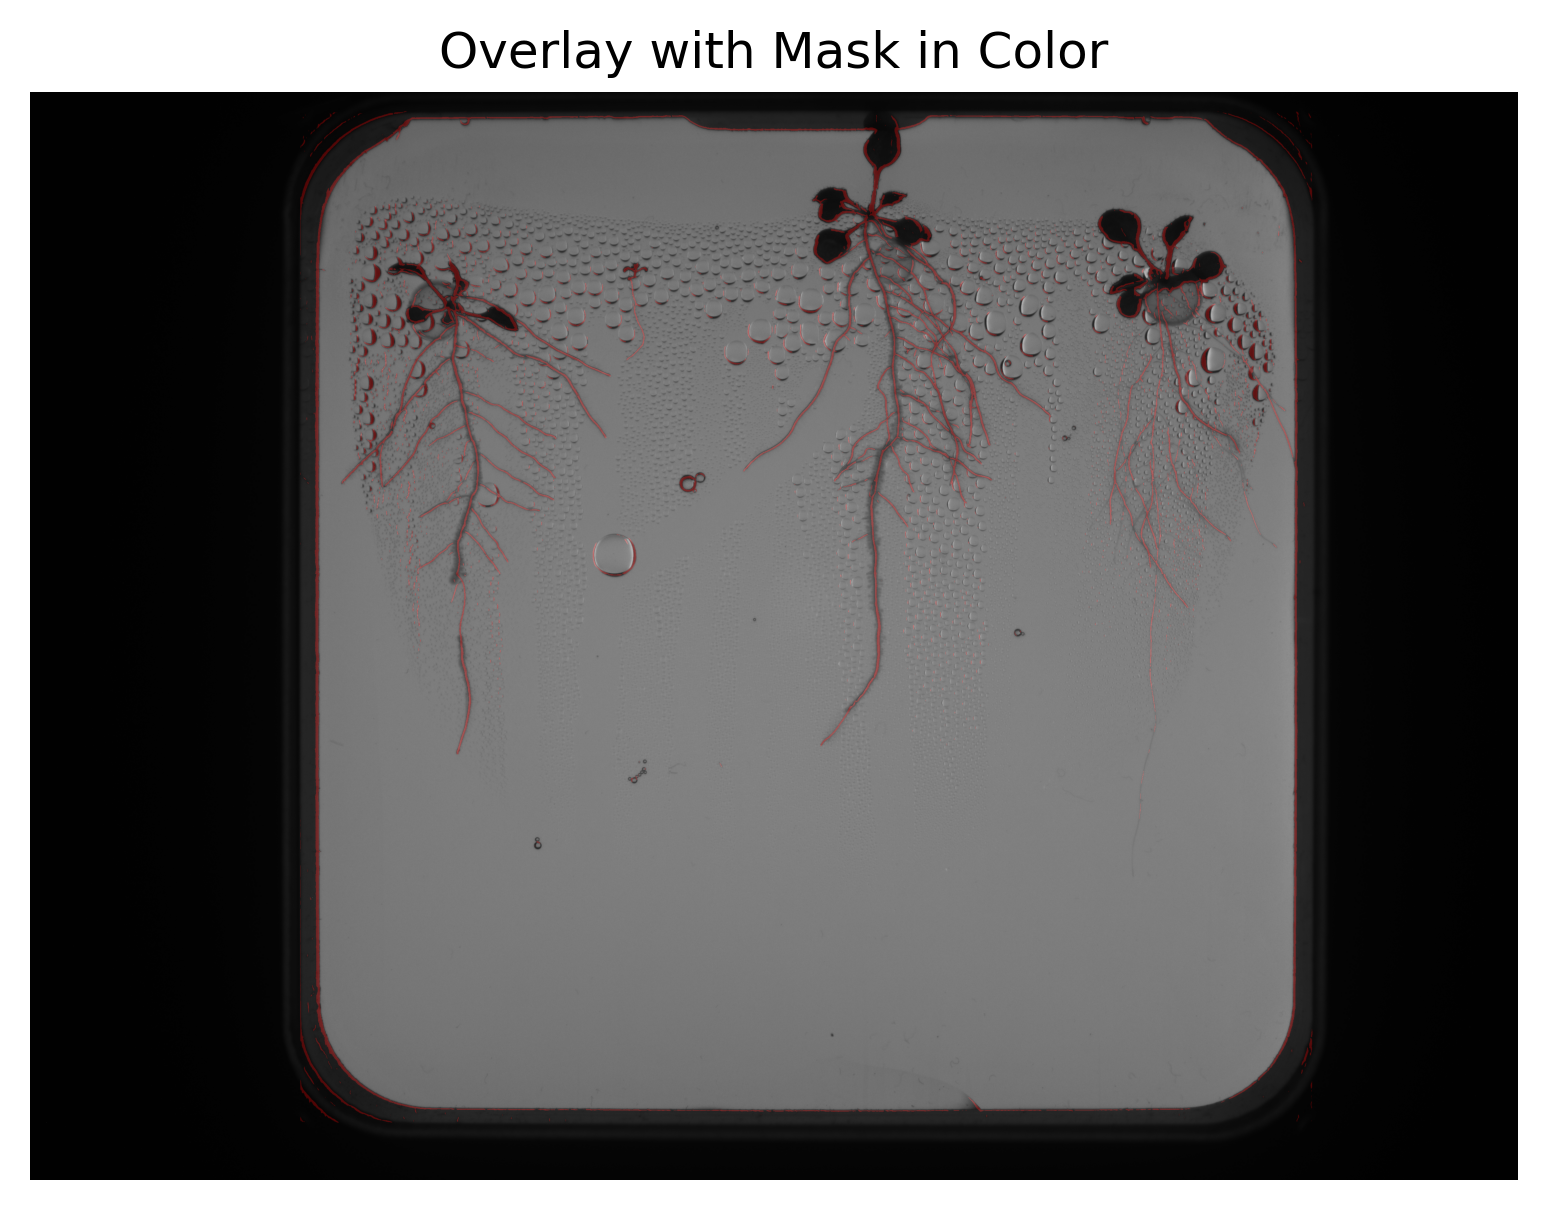

In [44]:
# Convert the original grayscale image to a 3-channel grayscale image
image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Convert the mask to a 3-channel binary mask with a specific color
mask_rgb = np.zeros_like(image_rgb)
mask_rgb[..., 2] = uncropped_mask  # Add the mask to the green channel (change index for other colors)

# Create the overlay
overlay_colored = cv2.addWeighted(image_rgb, 0.7, mask_rgb, 0.3, 0)

# Display the overlay
plt.figure(dpi=300)
plt.imshow(cv2.cvtColor(overlay_colored, cv2.COLOR_BGR2RGB))
plt.title("Overlay with Mask in Color")
plt.axis('off')
plt.show()


In [47]:
import cv2

# Normalize the uncropped mask to 0-255 range if not already normalized
uncropped_mask_normalized = (uncropped_mask / uncropped_mask.max() * 255).astype(np.uint8)

# Save the mask as a .tif file
cv2.imwrite('final_uncropped_root_mask.tif', uncropped_mask_normalized)
print("Saved final uncropped root mask as 'final_uncropped_root_mask.tif'")


Saved final uncropped root mask as 'final_uncropped_root_mask.tif'


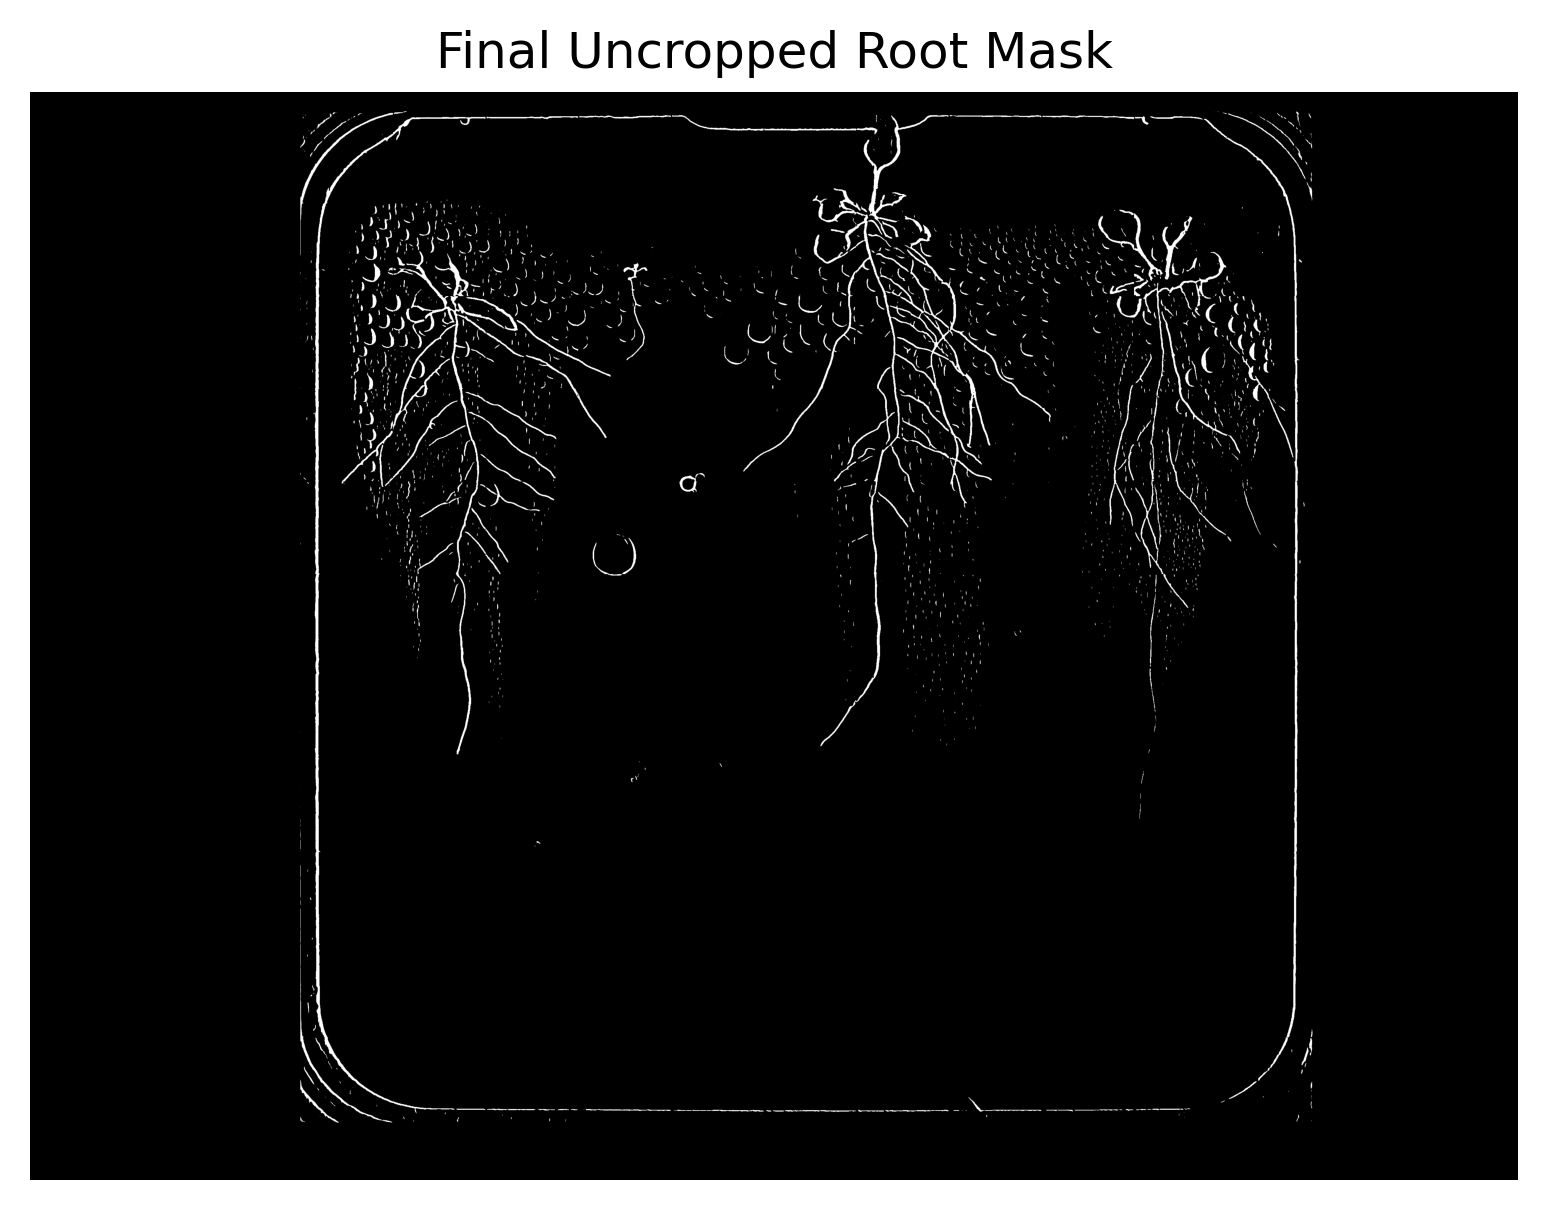

In [48]:
# Load the saved .tif file
saved_mask = cv2.imread('final_uncropped_root_mask.tif', cv2.IMREAD_GRAYSCALE)

# Display the saved mask
plt.figure(dpi=300)
plt.imshow(saved_mask, cmap='gray')
plt.title("Final Uncropped Root Mask")
plt.axis('off')
plt.show()


In [24]:
predicted_mask.shape, image.shape

((2816, 2816), (3006, 4112))

As you can see `predicted_mask` and `image` have different shapes. This is because of cropping and padding.

**REQUIREMENT:** The input and output should have the same size and should be aligned perfectly. To achieve this, you need to reverse the effects of cropping and padding added during processing. This will ensure the final mask aligns with the original image.

In [ ]:
# Apply the corrections

predicted_mask_corrected.shape

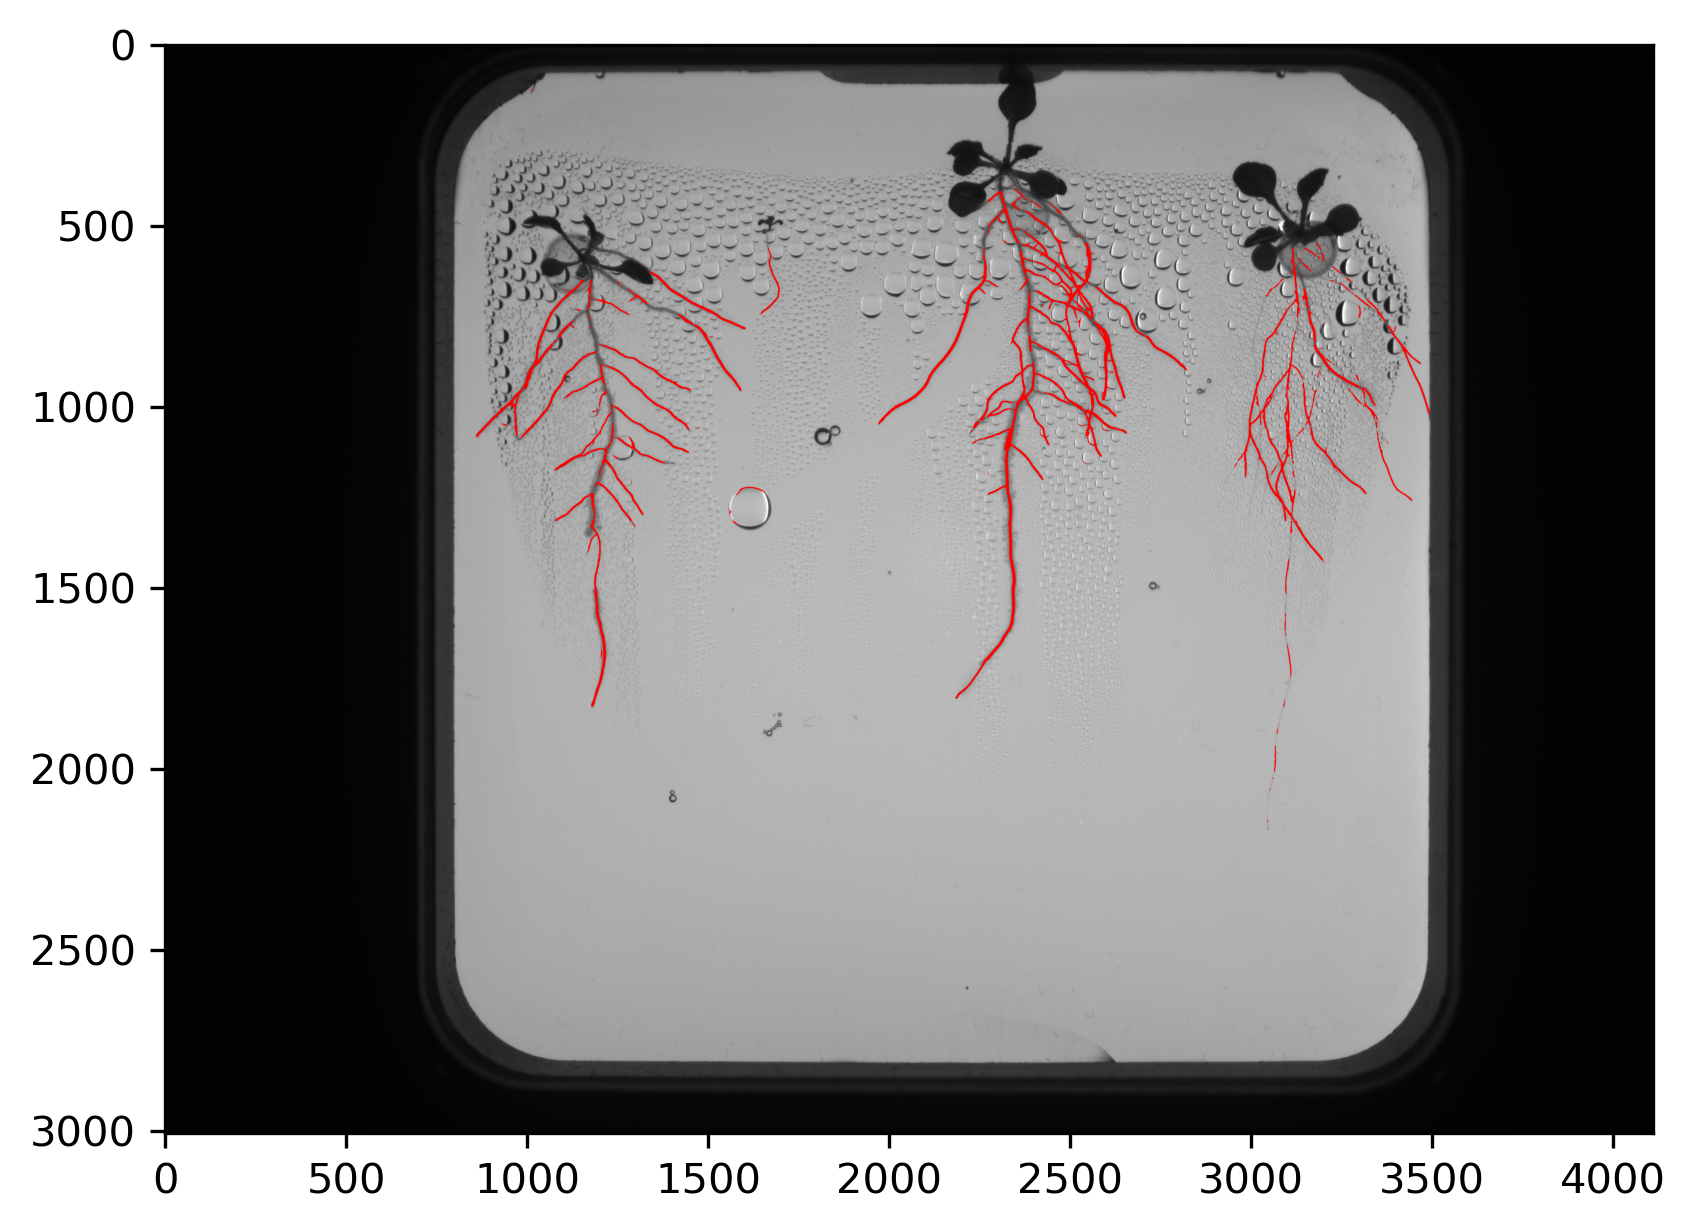

In [ ]:
# REQUIREMENT: Predicted roots must align with the original image.
# REQUIREMENT: Plot such an image to prove alignment.

plt.figure(dpi=300)
plt.imshow(overlay_image)

In [ ]:
# REQUIREMENT: Save the predicted mask, it is a deliverable.
# REQUIREMENT: Input/Output size must be the same.
# REQUIREMENT: Predicted roots must align with the original image.
# REQUIREMENT: The predicted mask must be binary.
# REQUIREMENT: Non-root pixels must be 0, root pixels must be 255 (unlike Task 1)
# REQUIREMENT: naming convention task5_test_image_prediction_studentname_studentnumber.png
mask_image = (predicted_mask_corrected * 255).astype(np.uint8)
assert(predicted_mask_corrected.shape == image.shape)
cv2.imwrite('PetarPaskalev_232725_unet_model_2_256px_80F1.h5', mask_image)

Note: I have trained the model on the Y2B_23 dataset, since there are no labels for Y2B_24 dataset yet. The test image is from Y2B_24, this is why the predicted mask is suboptimal. Therefore do not take the performance of this prediction as a reference. Your predictions should be much better than this.